In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [16]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
df.tail(20)

,id,time,experiment_id,gameid,real_reward,final_smiles
3668,5308,2020-10-20 14:52:56.236364,0003_noh,19a9b0c6,0.00000,[NH]C(=O)C(=O)C(=O)N1CC1
3669,5309,2020-10-20 14:52:56.526660,0003_noh,091a9f6f,72.85154,CC1=[C]C(=O)C(=O)N1C
3670,5310,2020-10-20 14:52:57.548642,0003_noh,733b1357,90.79536,CC(=O)C1=[C]C(=O)CCC1
3671,5311,2020-10-20 14:52:58.528363,0003_noh,d6d94d3d,0.00000,[CH2]N(C)C=O
3672,5312,2020-10-20 14:52:59.509160,0003_noh,d46aee70,61.23763,O=[C]OC(=O)C(=O)N1CC1
3673,5313,2020-10-20 14:53:01.295733,0003_noh,78b7e23f,90.79536,CC(=O)C1=[C]C(=O)CCC1
3674,5314,2020-10-20 14:53:02.220231,0003_noh,100e65e3,0.00000,[CH2]N(C)C=O
3675,5315,2020-10-20 14:53:02.534157,0003_noh,c22aadbf,0.00000,CN(C)C(=O)C(=O)C([O])=O
3676,5316,2020-10-20 14:53:02.760255,0003_noh,2c885ec7,0.00000,NC1=N[CH]1
3677,5317,2020-10-20 14:53:03.009959,0003_noh,42843041,90.79536,CC(=O)C1=[C]C(=O)CCC1


In [17]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

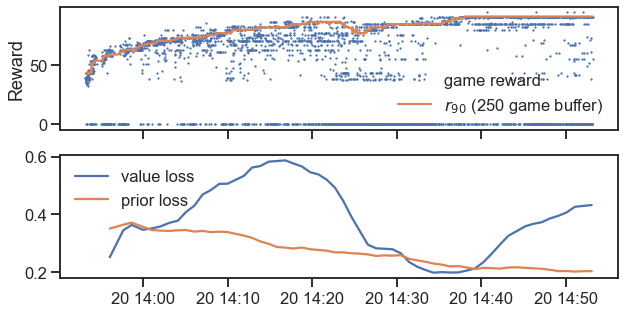

In [18]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [19]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(11538, 7)

In [20]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

In [21]:
rew_df.head()

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
0,CC(C)=[N],2020-10-20 13:16:17.548859,41.180405,N,29.320810,0.762808,3
1,[N]=C(N)O,2020-10-20 13:16:18.806879,38.228000,N,25.724133,0.749923,3
2,[CH]=C(O)CO,2020-10-20 13:16:19.701901,38.026016,C,30.488230,0.849244,3
3,CNC(=[N])N,2020-10-20 13:16:20.304624,40.233520,N,30.173529,0.798800,4
4,COC(=[N])N,2020-10-20 13:16:21.564976,41.589058,N,29.850115,0.765221,4


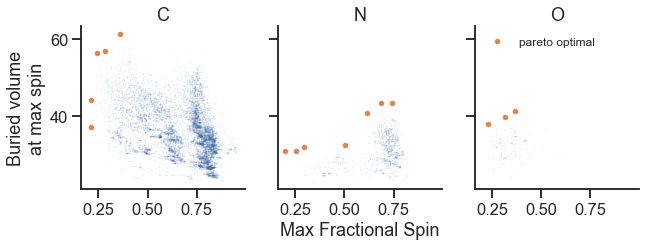

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?
* Also look into sulfur-containing radicals
* Some additional chemical feasibility constraints

In [ ]:
# rew_df.iloc[optimal[0]]